# Pólya-Gamma Logistic Regression + Thompson Sampling

This notebook will walk through an implementation of Polya-Gamma augmented logistic regression + Thompson Sampling. Specifically, it will summarize and reimplement the method described in:

> B. Dumitrascu, K. Feng, and B. E. Engelhardt, “PG-TS: Improved Thompson Sampling for Logistic Contextual Bandits,” arXiv:1805.07458 [cs, stat], May 2018.

## Notation

Basical mathematical notation:

-   $x \in \mathbb{R}^d$ denotes a $d$-dimensional column vector with scalar entries $x_j$, indexed by integers $j = \{1, 2, \ldots, d\}$
-   $\mathbf{X}$ denotes a square matrix, while $X$ refers to a random variable (RV)
-   We use $||.||$ for the 2-norm, while $||x||_A$ denotes $x^T\mathbf{A}x$, for a matrix $\mathbf{A}$
-   Let $\mathbb{1}_\mathcal{B}(x)$ be the indicator function of a set $\mathcal{B}$ defined as 1 if $x \in \mathcal{B}$ and 0 otherwise
-   $MVN(\mathbf{b}, \mathbf{B})$ denotes the multivariate normal distribution with mean $\mathbf{b}$ and covariance matrix $\mathbf{B}$, and $\mathbf{I}_d$ is the $d \times d$ identity matrix

Contextual bandit notation:

-   $\mathcal{A}$ is the set of arms and $|\mathcal{A}| = K$ is the number of arms
-   At each time step $t$, the learner observes context $\mathbf{x}_{t,a} \in \mathbb{R}^d$
-   The learner then chooses an arm $a_t$ and receives a reward $r_t \in \{0, 1\}$
-   The expectation of this reward is related to the context through a parameter $\mathbf{\theta^*} \in \mathbb{R}^d$ and a logistic link function $\text{logit}^{-1}$, abbreviated as $\mu$
-   Let $\mathcal{D}_t$ be the set of triplets $(x_{i, a_i}, a_i, r_i)$ for $i = 1, \ldots, t$, representing the past $t$ observations fo the contexts, actions chosen, and their corresponding rewards
-   The objective is to minimize cumulative regret given $\mathcal{D}_{t-1}$ after fixed budget of $t$ steps
-   Regret is the expected difference between optimal reward received by always playing optimal arm $a^*$ and actual reward received:

$$r_t = \sum_{i=1}^t \left[
\mu(\mathbf{x}_{i, a^*}^T \mathbf{\theta^*}) -
\mu(\mathbf{x}_{i, a_i}^T \mathbf{\theta^*})
\right]$$

The parameter $\theta$ is re-estimated after each round $t$ using a generalized lienar model (GLM) estimator, as $\theta_t$.

## Thompson Sampling for Contextual Logistic Bandits

Specify prior $p(\theta)$ and estimate posterior from observed triplets using Bayes' rule:

$$p(\theta | \mathcal{D}_{t-1}) \propto \prod_{i=1}^{t-1} p(r_i | a_i, \mathbf{x}_{ia, a_i}, \theta) p(\theta)$$

The optimal arm is then chosen according to the explicit TS probabilities $p(a_t = a^* | \theta_t, \mathcal{D}_{t-1})$, computed via:

$$\int \mathbb{1}_{\mathcal{A}_t^\text{max}}(\theta_t)
\left(E[r_t | a, \mathbf{x}_{t,a}, \theta_t] \right)
p(\theta_t | \mathcal{D}_{t-1}) d\theta_t,$$

where $\mathcal{A}_t^\text{max}(\theta_t)$ is the set of arms with maximum rewards at step $t$ if the true parameter were $\theta_t$.

In the case of logistic regression, the joint PMF over rewards $r_1, \ldots, r_t$ observed upon taking actions $a_1, \ldots, a_t$ is:

$$\prod_{i=1}^t p(r_i = 1 | a_i, \mathbf{x}_{i, a_i}, \theta_i) = \prod_{i=1}^t \text{Bernoulli}(\mu(\mathbf{x}_{i, a_i}^T \theta_i))$$

### Laplacian approximation

Since the posterior derived from this joint distribution is intractable, Laplace-TS (Chapelle and Li, 2011) approximates the MV Gaussian with a diagonal covariance matrix. The mean of this is a MAP estimate. Laplace-TS performs well compared to UCB and other approximate techniques used by Russo et al. in 2017.

### Polya-Gamma (PG) Data Augmentation

Reframe discrete rewards as functions of latent variables with Pólya-Gamma distributions over a continuous space. The PG latent variable construction relies on the theoretical properties of PG random variables to exploit the fact that **the logistic likelihood is a mixture of Gaussians with PG mixing distributions.**

**So what is a PG-distributed RV?** _Let $X$ be a real-valued RV. $X$ follows a PG distribution with parameters $b > 0$ and $c \in \mathbb{R}, X \sim PG(b, c)$ if_:

$$X =
\frac{1}{2\pi^2}
\sum_{k=1}^\infty \frac{G_k}{(k - 1/2)^2 + c^2/(4\pi^2)},$$

_where $G_k \sim Ga(b,1)$ are independent Gamma variables_.

The identity central to the PG augmentation scheme is:

$$\frac{exp(\psi)^a}{(1 + exp(\psi))^b} =
2^{-b} exp(\kappa \psi) \int_0^\infty exp(-\omega \psi^2 / 2) p(\omega) d\omega,$$

where $\psi \in \mathbb{R}, a \in \mathbb{R}, b > 0, \kappa = a - b/2$, and $\omega \sim PG(b, 0)$. When $\psi = \mathbf{x}_t^T \theta$, the previous identity allows us to write the logistic likelihood contribution of step $t$, $L_t(\theta)$ as:

\begin{align}
L_t(\theta)
    &= \frac{exp(\mathbf{x}_t^T \theta)^{r_t}}{1 + exp(\mathbf{x}_t^T \theta)}  \\
    &\propto exp(\kappa_t \mathbf{x}_t^T \theta) \int_0^\infty exp[-\omega_t (\mathbf{x}_t^T \theta)^2 / 2] p(\omega_t; 1, 0) d\omega_t,
\end{align}

where $\kappa_t = r_t - 1/2$ and $p(\omega_t; 1, 0)$ is the density of a PG-idstributed RV with parameters $(1, 0)$. These values result from appropriate substitution of $a=r_t$ and $b=1$ in the identity above.

With this formulation of the likelihood, the conditional posterior of $\theta$ given latent variables $\mathbf{\omega} = [\omega_1, \ldots, \omega_t]$ and past rewards $\mathbf{r} = [r_1, \ldots, r_t]$ is a Gaussian:

\begin{align}
p(\theta | \mathbf{\omega}, \mathbf{r})
    &= p(\theta) \prod_{i=1}^t L_i(\theta | \omega_i)  \\
    &\propto p(\theta) \prod_{i=1}^t exp\left\{\kappa_i \mathbf{x}_i^T \theta - \omega_i (\mathbf{x}_i^T \theta)^2 / 2 \right\}  \\
    &\propto p(\theta) \prod_{i=1}^t exp\left\{ \frac{\omega_i}{2} (\mathbf{x}_i^T \theta - \kappa_i / \omega_i)^2 \right\}  \\
    &\propto p(\theta) \ exp \left\{ -\frac{1}{2} (z - \mathbf{X}\theta)^T \mathbf{\Omega} (z - \mathbf{X}\theta) \right\},
\end{align}

where $z = (\kappa_1 / \omega_1, \ldots, \kappa_t / \omega_t)$, and $\mathbf{\Omega} = diag(\omega_1, \ldots, \omega_t)$. This is a conditionally Gaussian likelihood in $\theta$, with working responses $z$, design matrix $\mathbf{X}$, and diagonal covariance matrix $\mathbf{\Omega}^{-1}$.

With a multivariate Gaussian prior for $\theta \sim MVN(\mathbf{b}, \mathbf{B})$:

$$p(\theta) \propto exp\left\{ -\frac{1}{2} (\theta - \mathbf{b})^T \mathbf{B}^{-1} (\theta - \mathbf{b}) \right\},$$

this identity leads to an efficient Gibbs sampler. The main parameters are drawn from a Gaussian distribution, which is parameterized by latent variables drawn from the PG distribution. The two steps are:

\begin{align}
(\omega_i | \theta) &\sim PG(1, \mathbf{x}_i^T \theta)  \\
(\theta | \mathbf{r}, \mathbf{\omega}) &\sim N(\mathbf{m}_\omega, \mathbf{V}_\omega),
\end{align}

with

\begin{align}
\mathbf{V}_\omega &= (\mathbf{X}^T \mathbf{\Omega} \mathbf{X} + \mathbf{B}^{-1})^{-1}  \\
\mathbf{m}_\omega &= \mathbf{V}_\omega (\mathbf{X}^T \mathbf{\kappa} + \mathbf{B}^{-1}\mathbf{b})  \\
\mathbf{\kappa} &= [r_1 - 1/2, \ldots, r_t - 1/2]
\end{align}

![PG-TS-Algorithm](images/pg-ts-algorithm-snapshot.png)

Notes on the algorithm:

1.  $\mathbf{b}$ = prior means for coefficients
2.  $\mathbf{B}$ = prior covariance for coefficients
3.  $M$ = number of burn-in iterations. Set to 1 for "streaming" setting. Authors found $M = 100$ gave good mixing
4.  Initial draw $\theta_0$ is from the prior $MVN(\mathbf{b}, \mathbf{B})$

## Experiments from the paper

1.  Gaussian simulations. 100 arms and 10 features per context across 1,000 trials (time steps).
    -   Simulation process:
        -   Contexts generated via: $\mathbf{x}_{t,a} \sim MVN(-\mathbf{3}, \mathbf{I}_{10})$ for all arms $a$.
        -   True parameters $\theta^* \sim MVN(\mathbf{0}, \mathbf{I}_{10})$.
        -   **Set the hyperparameters to be $\mathbf{b} = 0$ and $\mathbf{B} = \mathbf{I}_{10}$.**
    -   Results averaged over 100 runs. Also looked at variability across runs.
    -   Found PG-TS performed better than Laplace-TS with less variability. Also found $M = 1$ is still better.
2.  Mixture of Gaussians simulations to examine prior misspecification. 100 arms, 10 features, 5,000 trials (time steps).
    -   Simulation process:
        -   Contexts generated via: $\mathbf{x}_{t,a} \sim MVN(\mathbf{0}, \mathbf{I}_{10})$
        -   True parameter $\theta^*$ sampled from 4-component GMM, specified as follows.
            -   variances $\sigma^2_{j=1:4} \sim \text{Inverse-Gamma}(3,1)$
            -   means $\mu_{j=1:4} \sim N(-3, \sigma_j^2)$
            -   mixture weights $\phi \sim \text{Dirichlet}(1, 3, 5, 7)$
            -   Then $\theta^*(i) \sim \sum_{j=1}^4 \phi_j N(\mu_j, \sigma_j^2),$ for $i = 1, \ldots, 10$.
    -   Found that PG-TS dealt with this misspecification better than Laplace-TS
3.  Forest Cover type data from UCI ML repo (Bay et al., 2000). Kind of an odd experiment, so not discussing it here.
4.  Yahoo! News article recommendation.
    -   Ran replay on 200K of the clickstream events from the dataset of Li et al., 2010.
        -   Did not discuss running it more than once and mention that $\le 24,000$ events were valid for each of the evaluated algorithms.
        -   This may indicate the authors failed to repeat the replay procedure, as should be done.
    -   Full dataset contains 45.8M user visits from first 10 days in May 2009. For each user visit, one article of $K \approx 20$ is shown.
    -   Each article is associated with a feature vector $\mathbf{x} \in \mathbb{R}^6$, including constant intercept feature, "preprocessed using a conjoint analysis with a bilinear model (Chu et al., 2009)..."
    -   Articles represent the pool of arms, binary payoff is CTR, goal is to maximize total CTR.
    -   Also include experiments with models updating in batches, introducing time delay (uses actual minutes of delay).
    -   Found that PG-TS performed best; has more performance advantage with less delay

# Game Plan from here

1.  Implement PG-TS algorithm and validate on the same simulated procedure described in Experiment 1
2.  Implement Laplace-TS algorithm and validate on Experiment 1
3.  Extend PG-TS to use IW on $\mathbf{B}$
4.  Relax (3) s.t. we have $\mathbf{B} = diag(\sigma^2_1, \ldots, \sigma^2_d)$ and $\sigma^2_j \sim IG(\alpha_j, \beta_j), j = 1, \ldots, d$

Potential extensions:

-   To improve expressiveness / reduce amount of tuning of hyperparameters:
    1.  Add an Inverse-Wishart (IW) prior on $\mathbf{B}$, since it's unclear how to properly set the prior covariance and that can have a significant impact
    2.  Constrain the covariance to be diagonal and use a separate Inverse-Gamma (IG) prior per variance entry $\sigma^2_j, j = 1, \ldots, d$ instead of the IW.
    3.  Constrain this further s.t. the covariance is $\mathbf{I}_d \times \sigma^2$, i.e. each $\theta$ is distributed according to the same variance, and $\sigma^2 \sim IG(\alpha, \beta)$.
    4.  Add a Gamma prior on the scale term(s) of the IG distributions, since we may not know what good settings for those are.
-   To handle non-stationarity:
    1.  Add a drift component to the coefficients using the formulation from Sarkka (special case of Kalman Filter).
    2.  Discount old data using some discount factor $\gamma \in (0, 1]$
    3.  Use a sliding window method: only fit the model on data in the last $W$ time steps
    4.  (Piecewise stationarity) Incorporate some sort of changepoint detection technique (perhaps the model-based Mahalonobis distance technique)

## Implement PG-TS algorithm and validate on the same simulated procedure described in Experiment 1

In [1]:
import os
import sys
import pickle
import logging
from concurrent import futures

import numpy as np
import pandas as pd
from scipy import stats
from scipy import special as sps
from pypolyagamma import PyPolyaGamma

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_style('whitegrid')

logging.basicConfig(
    level=logging.INFO, stream=sys.stdout,
    format="[%(asctime)s][%(levelname)s]: %(message)s")
logger = logging.getLogger()
%matplotlib inline

### Start by simulating data

In [2]:
# Simualate data
def simulate_gaussian_data(num_arms=5, num_predictors=3, num_time_steps=50,
                           prior_means=None, prior_cov=None, *, seed=42):
    rng = np.random.RandomState(seed)

    # Generate true effects
    if prior_means is None:
        prior_means = np.zeros(num_predictors, dtype=np.float)

    if prior_cov is None:
        prior_cov = np.identity(num_predictors, dtype=np.float)

    true_effects = rng.multivariate_normal(prior_means, prior_cov)
    print(f'True effects: {np.round(true_effects, 4)}')

    # Generate design matrix
    arm_contexts = rng.multivariate_normal(
        np.ones(num_predictors, dtype=np.float) * -3,
        np.identity(num_predictors, dtype=np.float),
        size=num_arms)
    print(f'Context matrix size: {arm_contexts.shape}')

    # Generate multiple points for each arm, using round-robin routing.
    arm_per_time_step = rng.choice(num_arms, size=num_time_steps)
    print(f'Samples per arm: {np.bincount(arm_per_time_step)}')

    design_matrix = arm_contexts[arm_per_time_step]
    print(f'Design matrix size: {design_matrix.shape}')

    logits = design_matrix.dot(true_effects)
    rates = sps.expit(logits)
    ys = rng.binomial(n=1, p=rates)

    return true_effects, rates, design_matrix, ys


true_effects, rates, design_matrix, ys = simulate_gaussian_data()

True effects: [ 0.4967 -0.1383  0.6477]
Context matrix size: (5, 3)
Samples per arm: [ 7 14  4 17  8]
Design matrix size: (50, 3)


### Next implement PG-TS

In [3]:
def draw_omegas(design_matrix, theta, pg_rng):
    num_rows = design_matrix.shape[0]
    omegas = np.ndarray(num_rows)
    logits = design_matrix.dot(theta)
    for i, logit_i in enumerate(logits):
        omegas[i] = pg_rng.pgdraw(1, logit_i)

    return omegas


rng = np.random.RandomState(42)
pg_rng = PyPolyaGamma(seed=rng.randint(0, 2**32))
omegas = draw_omegas(design_matrix, true_effects, pg_rng)
omegas

array([0.1596743 , 0.19215274, 0.1063296 , 0.27367247, 0.06560533,
       0.07586653, 0.07163043, 0.48742697, 0.02822869, 0.07179553,
       0.27181091, 0.1635008 , 0.06916429, 0.11194476, 0.15172441,
       0.17550561, 0.23778709, 0.02816743, 0.09748887, 0.29285089,
       0.23887754, 0.31857353, 0.2625747 , 0.24508967, 0.57150317,
       0.03817422, 0.15944416, 0.27623028, 0.14832688, 0.2003983 ,
       0.01697209, 0.31636999, 0.11772438, 0.062571  , 0.03449791,
       0.08137764, 0.03425237, 0.07642094, 0.18203002, 0.17351637,
       0.05701904, 0.35682142, 0.18805591, 0.09362211, 0.11442617,
       0.17135459, 0.03964136, 0.04697371, 0.03756138, 0.04917412])

Just out of curiousity, what is the fastest way to compute X.T.dot(Omega)?

In [4]:
Omega = np.diag(omegas)
np.array_equal(design_matrix.T.dot(Omega), design_matrix.T * omegas)

True

In [5]:
# What is the fastest way to compute X.T.dot(Omega)?
from scipy import sparse

In [6]:
%%timeit
design_matrix.T.dot(np.diag(omegas))

6.2 µs ± 258 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
%%timeit
design_matrix.T.dot(sparse.diags(omegas))

4.02 ms ± 277 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%%timeit
design_matrix.T * omegas

2.08 µs ± 121 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


And now on to the actual PG-TS Gibbs sampler implementation.

In [4]:
# Implement PG-TS Gibbs sampler
class NotFitted(Exception):
    pass


class Seedable:
    
    def __init__(self, seed=42):
        self._initial_seed = seed
        self.rng = np.random.RandomState(self._initial_seed)

    def seed(self, seed):
        self.rng.seed(seed)
        return self

    def reset(self):
        self.seed(self._initial_seed)
        return self


class BaseModel(Seedable):
    """Provides some useful helper methods and properties."""

    @property
    def param_names(self):
        return [name for name in self.__dict__ if name.endswith('_')]

    def iter_params(self):
        for name, value in self.__dict__.items():
            if name.endswith('_'):
                yield name, value

    def raise_if_not_fitted(self):
        empty_params = []
        for name, value in self.iter_params():
            if value is None:
                empty_params.append(name)

        if empty_params:
            raise NotFitted(f"some parameters are None: {empty_params}")


class LogisticRegression(BaseModel):
    """Bayesian logistic regression model, fitted with PG-augmented Gibbs."""
    
    def __init__(self, m0=None, P0=None, num_samples=100, num_burnin=0, **kwargs):
        """
        Args:
            m0 (np.ndarray): prior mean
            P0 (np.ndarray): prior covariance matrix
        """
        super().__init__(**kwargs)

        # Hyperparameters
        self.m0 = m0
        self.P0 = P0

        # Set other properties that control fitting
        self.num_samples = num_samples
        self.num_burnin = num_burnin
        self.pg_rng = PyPolyaGamma(seed=self.rng.randint(0, 2**32))

        # Set up empty parameters
        self.beta_hat_ = None

    def seed(self, seed):
        super().seed(seed)
        self.pg_rng = PyPolyaGamma(seed=self.rng.randint(0, 2**32))
        return self

    def reset(self):
        super().reset()
        self.beta_hat_ = None
        return self

    # Use custom pickling to handle non-serializable PG RNG
    # WARNING: pickle + unpickle will reset seed
    def __getstate__(self):
        state = self.__dict__.copy()
        del state['pg_rng']
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)
        self.reset()

    def sample_from_prior(self):
        return self.rng.multivariate_normal(self.m0, self.P0)

    def fit(self, X, y):
        """Fit the model using Gibbs sampler.

        Args:
            X (np.ndarray): design matrix
            y (np.ndarray): responses (binary rewards)

        Returns:
            self: reference to fitted model object (this instance).
        """
        # Precompute some values that will be re-used in loops
        P0_inv = np.linalg.inv(self.P0)
        P0_inv_m0 = P0_inv.dot(self.m0)
        kappas = (y - 0.5).T
        num_predictors = X.shape[1]

        # Init memory for parameter traces
        beta_hat = np.ndarray((self.num_samples + 1, num_predictors))

        # Init trace from prior
        beta_hat[0] = self.sample_from_prior()

        for i in range(1, self.num_samples + 1):
            omegas = draw_omegas(X, beta_hat[i - 1], self.pg_rng)

            # TODO: speed this up by computing inverse via Cholesky decomposition
            V_omega = np.linalg.inv((X.T * omegas).dot(X) + P0_inv)
            m_omega = V_omega.dot(X.T.dot(kappas) + P0_inv_m0)

            beta_hat[i] = rng.multivariate_normal(m_omega, V_omega)

        # Set fitted parameters on instance
        self.beta_hat_ = beta_hat[1:]  # discard initial sample from prior
        return self

    def transform(self, X, num_burnin=None):
        self.raise_if_not_fitted()

        # Optionally override default burnin.
        num_burnin = self.num_burnin if num_burnin is None else num_burnin
        beta_trace = self.beta_hat_[num_burnin:]

        # Compute logits and then transform to rates
        logits = X.dot(beta_trace.T)
        return sps.expit(logits)

    def choose_arm(self, context):
        if self.beta_hat_ is None:
            beta_hat = self.rng.multivariate_normal(self.m0, self.P0)
        else:
            beta_hat = self.beta_hat_[-1]

        # Compute logits and then transform to rates
        logits = context.dot(beta_hat)
        rates = sps.expit(logits)
        
        # Choose best arm for this "plausible model."
        return np.argmax(rates)

### Validate the model on synthetic data

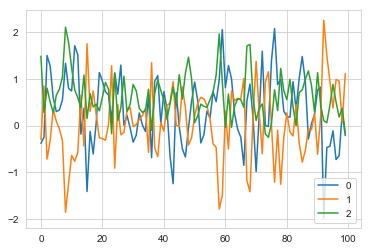

In [5]:
num_predictors = design_matrix.shape[1]
model = LogisticRegression(
    m0=np.zeros(num_predictors),
    P0=np.identity(num_predictors, dtype=np.float),
    num_samples=100)
model.fit(design_matrix, ys)

beta_trace = model.beta_hat_
pd.DataFrame(beta_trace).plot();

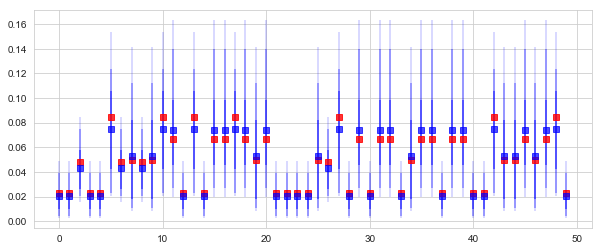

In [6]:
# Posterior rates
rates_trace = model.transform(design_matrix, num_burnin=50)
expected_rates = np.mean(rates_trace, axis=-1)
credible_bands = [(5.0, 95.0), (10.0, 90.0), (25.0, 75.0)]
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(rates, 's', color='red', alpha=0.8)
ax.plot(expected_rates, 's', color='blue', alpha=0.7)

xpoints = np.arange(len(rates))
for i, q in enumerate(credible_bands, start=1):
    lo, hi = np.percentile(rates_trace, q=q, axis=-1)
    plt.vlines(xpoints, lo, hi, color='blue', alpha=i * 0.2);

Next we'll combine the two plots above into a modular `ModelValidator` class that can be re-used elsewhere and doesn't have us working with so much global state.

In [7]:
class ModelValidator:
    """Fit Bayesian regression models and validate their outputs."""
    
    def __init__(self, model, credible_bands=(90, 80, 50)):
        self.model = model
        self.credible_bands = credible_bands

    def validate(self, X, y, rates):
        self.model.fit(X, y)
        self.traceplot()
        self.recapture_plot(X, rates)

    def traceplot(self, fontsize=14):
        num_params = len(self.model.param_names)
        fig, axes = plt.subplots(nrows=num_params, figsize=(10, num_params * 3.5),
                                 squeeze=False)

        for ax, (param_name, value) in zip(axes.flat, self.model.iter_params()):
            # TODO: only supports 1D parameters
            num_samples, cardinality = value.shape
            individual_names = [f'{param_name}{i}' for i in range(cardinality)]
            param_df = pd.DataFrame(
                value, columns=pd.Index(individual_names, 'Parameters'),
                index=pd.Index(np.arange(num_samples), name='Posterior Samples'))
            param_df.plot(ax=ax)

            # Pretty it up
            ax.set_title(param_name[:-1], fontsize=fontsize + 2)
            ax.set_ylabel(f'Support({param_name[:-1]})', fontsize=fontsize)
            ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize)

        return axes

    def recapture_plot(self, X, rates, fontsize=14):
        rates_trace = self.model.transform(X)
        expected_rates = np.mean(rates_trace, axis=-1)

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.set_title('Rate Recapture', fontsize=fontsize + 2)
        ci_labels = ','.join(f'{width}%' for width in self.credible_bands)
        ax.set_xlabel(f'Data (red) and Expected Value with {ci_labels} CIs (blue)',
                      fontsize=fontsize)
        ax.set_ylabel('Rate', fontsize=fontsize)

        # Plot actual rates along with expected value (estimate)
        ax.plot(rates, 's', color='red', alpha=0.8, label='actual')
        ax.plot(expected_rates, 's', color='blue', alpha=0.7, label='expected')
        ax.legend()

        # Plot vertical lines representing credible intervals of various widths.
        # First sort widths in descending order; we'll use this ordering to plot
        # with increasingly bold lines to show increasing credibility.
        widths = list(sorted(self.credible_bands, reverse=True))
        credible_bands = [(50 - width / 2, 50 + width / 2)
                          for width in widths]

        xpoints = np.arange(len(rates))
        for i, q in enumerate(credible_bands, start=1):
            lo, hi = np.percentile(rates_trace, q=q, axis=-1)
            plt.vlines(xpoints, lo, hi, color='blue', alpha=i * 0.2)

        return ax

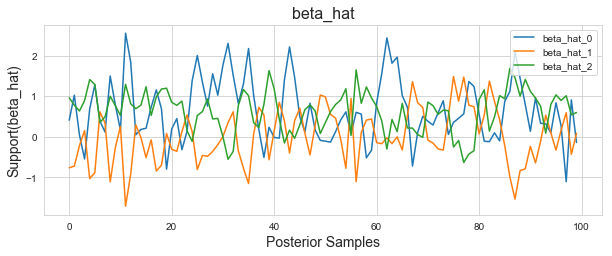

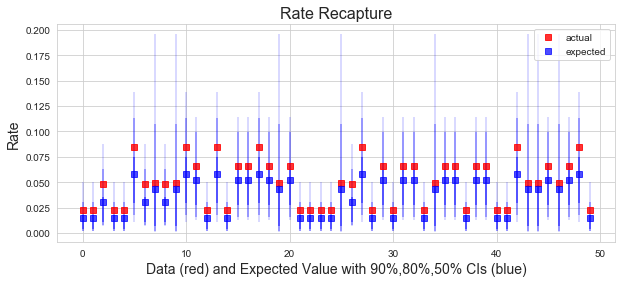

In [8]:
ModelValidator(model).validate(design_matrix, ys, rates)

## Implement Laplace-TS algorithm and validate on Experiment 1

![Laplace-TS](images/laplace-ts-algorithm-snapshot.png)

In [9]:
# We'll use scipy's optimize routine for the MAP estimate.
# This is for computing the minimizer in the algorithm above.
from scipy import optimize

In [10]:
m0 = np.zeros(num_predictors)
q0 = np.ones(num_predictors)

# This is the form from the original paper, which
# didn't work for me.
def reg_laplace_log_likelihood(w, X, y, m, q):
    logits = X.dot(w)
    return (0.5 * q.dot((w - m) ** 2) + 
            np.sum(np.log1p(np.exp(-y * logits))))

# This is the form from Bishop's PRML (p. 218)
def posterior_neg_log_likelihood(w, X, t, m, q):
    logits = X.dot(w)
    y = sps.expit(logits)
    # diff = w - m
    # P0 = np.diag(1 / q)
    # diff.dot(P0).dot(diff) - 
    return (0.5 * q.dot((w - m) ** 2) -
            np.sum(t * np.log(y) + (1 - t) * np.log1p(-y)))

optimization_result = optimize.minimize(
    posterior_neg_log_likelihood,
    x0=np.random.normal(0, 0.001, size=num_predictors),
    args=(design_matrix, ys, m0, q0))
print(optimization_result)

w_hat = optimization_result.x
list(zip(true_effects, w_hat))

      fun: 8.219890974034909
 hess_inv: array([[ 0.52679597, -0.29611805, -0.02775451],
       [-0.29611805,  0.46026717, -0.24328135],
       [-0.02775451, -0.24328135,  0.26892651]])
      jac: array([4.76837158e-07, 7.15255737e-07, 2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 70
      nit: 11
     njev: 14
   status: 0
  success: True
        x: array([0.36772034, 0.04376781, 0.60563244])


[(0.4967141530112327, 0.3677203375291891),
 (-0.13826430117118466, 0.04376780946877017),
 (0.6476885381006925, 0.6056324361365174)]

In [11]:
m = w_hat
p = sps.expit(design_matrix.dot(m))[:, None]
q = q0 + np.sum(design_matrix ** 2 * p * (1 - p), axis=0)
m, q

(array([0.36772034, 0.04376781, 0.60563244]),
 array([10.76512493, 23.3586422 , 25.67900673]))

In [12]:
dists = [stats.norm(m[i], np.sqrt(1 / q[i]))
         for i in range(num_predictors)]
[dist.interval(.95) for dist in dists]

[(-0.22964298494501023, 0.9650836600033884),
 (-0.3617634102047772, 0.44929902914231756),
 (0.21885691451571082, 0.9924079577573239)]

In [13]:
dist = stats.multivariate_normal(m, np.diag(1 / q))
dist.rvs(100).mean(axis=0)

array([0.3982745 , 0.04558834, 0.59018002])

Now let's convert this code into a class that fits our interface.

In [14]:
class LaplaceLogisticRegression(BaseModel):
    """Bayesian logistic regression model, fitted with Laplace approximation."""
    
    def __init__(self, m0=None, q0=None, num_samples=100, **kwargs):
        """
        Args:
            m0 (np.ndarray): prior mean
            q0 (np.ndarray): prior precision matrix diagonal
        """
        super().__init__(**kwargs)

        # Hyperparameters
        self.m0 = m0
        self.q0 = q0

        # Set other properties that control fitting
        self.num_samples = num_samples

        # Set up empty parameters
        self.beta_dist = stats.multivariate_normal(self.m0, np.diag(1 / self.q0))
        self.beta_hat_ = None

    def reset(self):
        super().reset()
        self.beta_dist = stats.multivariate_normal(self.m0, np.diag(1 / self.q0))
        self.beta_hat_ = None
        return self

    def fit(self, X, y):
        """Fit the model using Laplacian approximation.

        Args:
            X (np.ndarray): design matrix
            y (np.ndarray): responses (binary rewards)

        Returns:
            self: reference to fitted model object (this instance).
        """
        # First we need to find the mode of the posterior distribution.
        num_predictors = X.shape[1]
        optimization_result = optimize.minimize(
            posterior_neg_log_likelihood,
            x0=np.random.normal(0, 0.001, size=num_predictors),
            args=(X, y, self.m0, self.q0))
        mean_map_estimate = optimization_result.x
        
        # Next we "fit" a Gaussian centered at this posterior mode.
        # The computations below compute the covariance matrix by
        # taking the inverse of the matrix of second derivatives of
        # the negative log likelihood (see Bishop 4.5 for more details).
        m = mean_map_estimate  # retain notation from Chapelle paper
        p = sps.expit(X.dot(m))[:, None]
        q = self.q0 + np.sum(X ** 2 * p * (1 - p), axis=0)
        cov = np.diag(1 / q)  # q is precision

        # Set fitted parameters on instance
        self.beta_dist = stats.multivariate_normal(m, cov)
        self.beta_hat_ = self.beta_dist.rvs(self.num_samples, random_state=self.rng)
        return self

    def transform(self, X):
        self.raise_if_not_fitted()

        # Compute logits and then transform to rates
        logits = X.dot(self.beta_hat_.T)
        return sps.expit(logits)

    def choose_arm(self, context):
        beta_sample = self.beta_dist.rvs(random_state=self.rng)
        logits = context.dot(beta_sample)
        rates = sps.expit(logits)
        return np.argmax(rates)

In [15]:
model = LaplaceLogisticRegression(
    m0=np.zeros(num_predictors), q0=np.ones(num_predictors))
model.fit(design_matrix, ys)

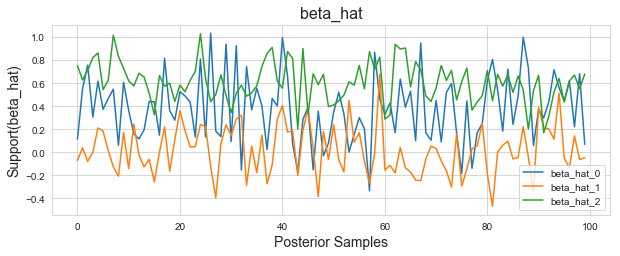

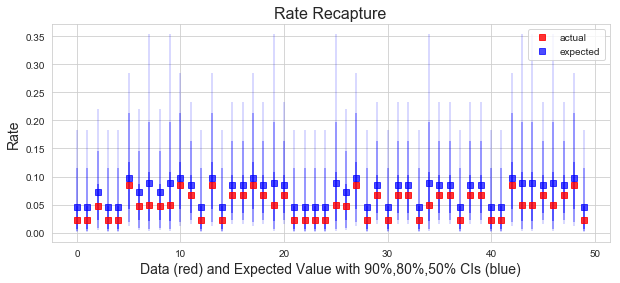

In [16]:
ModelValidator(model).validate(design_matrix, ys, rates)

### Replicate Experiment 1 from Paper

In [17]:
class GaussianSimulationFactory(Seedable):
    """Simulate data according to contextual Gaussian distributions.

    A factory creates individual environments.
    This particular factory creates `GaussianSimulationEnvironment`s.
    """

    def __init__(self, num_arms=100, num_predictors=10, num_time_steps=1000,
                 prior_effect_means=None, prior_effect_cov=None, **kwargs):
        super().__init__(**kwargs)

        self.num_arms = num_arms
        self.num_predictors = num_predictors
        self.num_time_steps = num_time_steps

        # Set prior parameters for effects
        self.prior_effect_means = prior_effect_means
        if self.prior_effect_means is None:
            self.prior_effect_means = np.zeros(
                self.num_predictors, dtype=np.float)

        self.prior_effect_cov = prior_effect_cov
        if self.prior_effect_cov is None:
            self.prior_effect_cov = np.identity(
                self.num_predictors, dtype=np.float)

    def __call__(self):
        # Generate true effects
        true_effects = self.rng.multivariate_normal(
            self.prior_effect_means, self.prior_effect_cov)
        logger.info(f'True effects: {np.round(true_effects, 4)}')

        # Generate design matrix
        arm_contexts = self.rng.multivariate_normal(
            np.ones(self.num_predictors, dtype=np.float) * -3,
            np.identity(self.num_predictors, dtype=np.float),
            size=self.num_arms)
        logger.info(f'Context matrix size: {arm_contexts.shape}')

        return GaussianSimulationEnvironment(
            true_effects, arm_contexts, seed=self.rng.randint(0, 2**32))


class GaussianSimulationEnvironment(Seedable):
    """An environment with Gaussian-distributed rewards related to
    contextual covariates linearly through a logistic link function.

    To replicate an experiment with the same environment but different
    random seeds, simply change the random seed after the first experiment
    is complete. If running in parallel, create multiple of these objects
    with different random seeds but the same parameters otherwise.
    """

    def __init__(self, true_effects, arm_contexts, **kwargs):
        super().__init__(**kwargs)

        self.true_effects = true_effects
        self.arm_contexts = arm_contexts
        self.arm_rates = self._recompute_arm_rates()
        self.optimal_arm = np.argmax(self.arm_rates)
        self.optimal_rate = self.arm_rates[self.optimal_arm]

    def _recompute_arm_rates(self):
        logits = self.arm_contexts.dot(self.true_effects)
        return sps.expit(logits)

    @property
    def num_arms(self):
        return self.arm_contexts.shape[0]

    @property
    def num_predictors(self):
        return self.arm_contexts.shape[1]

    def __str__(self):
        return (f'{self.__class__.__name__}'
                f', num_predictors={self.num_predictors}'
                f', num_arms={self.num_arms}'
                f', max_arm_rate={np.round(np.max(self.arm_rates), 5)}'
                f', mean_arm_rate={np.round(np.mean(self.arm_rates), 5)}')

    def __repr__(self):
        return self.__str__()

    def choose_arm(self, i):
        self._validate_arm_index(i)

        # Generate data for optimal arm.
        y_optimal = self.rng.binomial(n=1, p=self.optimal_rate)

        # Generate data for selected arm.
        context = self.arm_contexts[i]
        if i == self.optimal_arm:
            y = y_optimal
        else:
            y = self.rng.binomial(n=1, p=self.arm_rates[i])

        return context, y, y_optimal

    def _validate_arm_index(self, i):
        if i < 0 or i >= self.num_arms:
            raise ValueError(
                f'arm a must satisfy: 0 < a < {self.num_arms}; got {i}')


class Experiment(Seedable):
    """Run one or more replicates of agent-environment interaction
    and record the resulting metrics.
    """

    def __init__(self, environment_factory, model,
                 num_time_steps=1000, logging_frequency=100,
                 max_workers=7, **kwargs):
        super().__init__(**kwargs)

        self.environment = environment_factory()
        self.model = model
        self.num_time_steps = num_time_steps
        self.logging_frequency = logging_frequency
        self.max_workers = max_workers

    def run(self, num_replications=1):
        rep_nums = np.arange(num_replications)
        with futures.ProcessPoolExecutor(max_workers=self.max_workers) as pool:
            all_rewards = pool.map(self.run_once, rep_nums)

        rewards, optimal_rewards = list(zip(*all_rewards))
        return np.array(rewards), np.array(optimal_rewards)

    def run_once(self, seed):
        design_matrix = np.ndarray(
            (self.num_time_steps, self.environment.num_predictors))
        rewards = np.ndarray(self.num_time_steps)
        optimal_rewards = np.ndarray(self.num_time_steps)
        arm_selected = np.ndarray(self.num_time_steps, dtype=np.uint)

        self.model.seed(seed).reset()
        self.environment.seed(seed)

        logger.info(f'Experiment_{seed} beginning...')
        for t in range(self.num_time_steps):
            if (t + 1) % self.logging_frequency == 0:
                logger.info(f'Experiment_{seed} at t={t + 1}')

            arm_selected[t] = self.model.choose_arm(self.environment.arm_contexts)
            design_matrix[t], rewards[t], optimal_rewards[t] = \
                self.environment.choose_arm(arm_selected[t])
            self.model.fit(design_matrix[:t], rewards[:t])

        logger.info(f'Experiment_{seed} complete.')
        return rewards, optimal_rewards

[2019-03-03 06:13:54,276][INFO]: True effects: [ 0.3705  0.5342  2.9009 -0.4323  0.275   1.428   0.4041 -0.0516 -2.7478
 -0.181 ]
[2019-03-03 06:13:54,278][INFO]: Context matrix size: (100, 10)


GaussianSimulationEnvironment, num_predictors=10, num_arms=100, max_arm_rate=0.99213, mean_arm_rate=0.07991

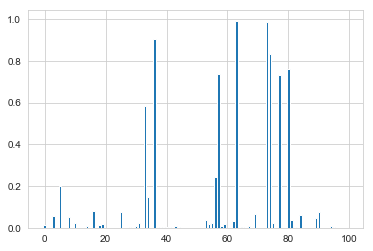

In [18]:
factory = GaussianSimulationFactory(seed=2135)
environment = factory()
plt.bar(np.arange(environment.num_arms), environment.arm_rates)
environment

### PG-TS with M=100

In [23]:
def contains_all(dirpath, *filenames):
    listing = os.listdir(dirpath)
    return all(fname in listing for fname in filenames)

In [25]:
if not contains_all('data', 'pg_ts_rewards.pkl', 'pg_ts_optimal_rewards.pkl'):
    factory.reset()
    model = LogisticRegression(
        m0=np.zeros(factory.num_predictors),
        P0=np.identity(factory.num_predictors, dtype=np.float),
        num_samples=100)
    experiment = Experiment(factory, model, logging_frequency=500)
    pg_ts_rewards, pg_ts_optimal_rewards = experiment.run(num_replications=100)

    # Save results from PG-TS experiments.
    with open('data/pg_ts_rewards.pkl', 'wb') as f:
        pickle.dump(pg_ts_rewards, f)

    with open('data/pg_ts_optimal_rewards.pkl', 'wb') as f:
        pickle.dump(pg_ts_optimal_rewards, f)
else:
    # Load results from PG-TS experiments.
    with open('data/pg_ts_rewards.pkl', 'rb') as f:
        pg_ts_rewards = pickle.load(f)

    with open('data/pg_ts_optimal_rewards.pkl', 'rb') as f:
        pg_ts_optimal_rewards = pickle.load(f)

In [28]:
def plot_cum_regret(rewards, optimal_rewards, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=kwargs.pop('figsize', None))

    regret = optimal_rewards - rewards
    cum_regret = np.cumsum(regret, axis=-1)
    pd.DataFrame(cum_regret.T).plot(
        ax=ax,
        color=kwargs.get('color', 'red'),
        alpha=kwargs.get('alpha', 0.5))

    fontsize = kwargs.pop('fontsize', 14)
    ax.set_ylabel('Cumulative Regret', fontsize=fontsize)
    ax.set_xlabel('Trial Number', fontsize=fontsize)
    ax.get_legend().remove()
    ax.set_title(kwargs.get('title', ''), fontsize=fontsize + 2)

    return ax

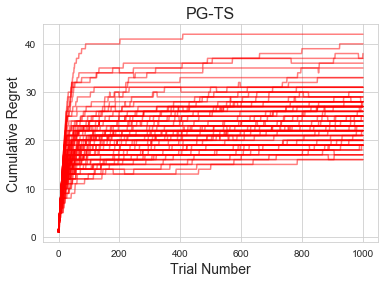

In [29]:
plot_cum_regret(pg_ts_rewards, pg_ts_optimal_rewards, title='PG-TS');

### PG-TS with M=1 (PG-TS-Stream)

In [26]:
if not contains_all('data', 'pg_ts_stream_rewards.pkl', 'pg_ts_stream_optimal_rewards.pkl'):
    factory.reset()
    model = LogisticRegression(
        m0=np.zeros(factory.num_predictors),
        P0=np.identity(factory.num_predictors, dtype=np.float),
        num_samples=2)  # first sample discarded as burnin
    experiment = Experiment(factory, model, logging_frequency=500)
    pg_ts_stream_rewards, pg_ts_stream_optimal_rewards = experiment.run(num_replications=100)

    # Save results from PG-TS-Stream experiments.
    with open('data/pg_ts_stream_rewards.pkl', 'wb') as f:
        pickle.dump(pg_ts_stream_rewards, f)

    with open('data/pg_ts_stream_optimal_rewards.pkl', 'wb') as f:
        pickle.dump(pg_ts_stream_optimal_rewards, f)
else:
    # Load results from PG-TS-Stream experiments.
    with open('data/pg_ts_stream_rewards.pkl', 'rb') as f:
        pg_ts_stream_rewards = pickle.load(f)

    with open('data/pg_ts_stream_optimal_rewards.pkl', 'rb') as f:
        pg_ts_stream_optimal_rewards = pickle.load(f)

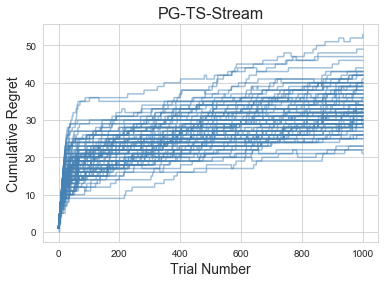

In [30]:
plot_cum_regret(pg_ts_stream_rewards, pg_ts_stream_optimal_rewards,
                color='steelblue', title='PG-TS-Stream');

#### Combined PG-TS plots

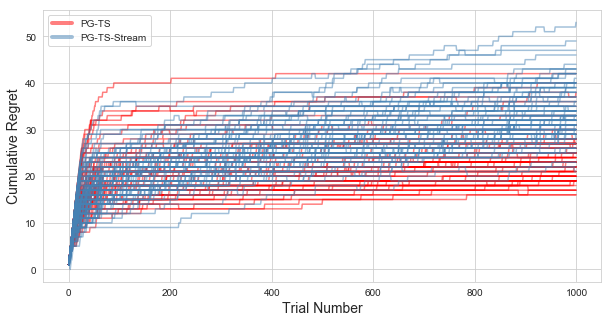

In [31]:
ax = plot_cum_regret(pg_ts_rewards, pg_ts_optimal_rewards, figsize=(10, 5))
plot_cum_regret(pg_ts_stream_rewards, pg_ts_stream_optimal_rewards,
                ax=ax, color='steelblue');

ax.legend([Line2D([0], [0], color='red', alpha=0.5, lw=4),
           Line2D([0], [0], color='steelblue', alpha=0.5, lw=4)],
          ['PG-TS', 'PG-TS-Stream']);

In [32]:
if not contains_all('data', 'laplace_ts_rewards.pkl', 'laplace_ts_optimal_rewards.pkl'):
    factory.reset()
    model = LaplaceLogisticRegression(
        m0=np.zeros(factory.num_predictors),
        q0=np.ones(factory.num_predictors, dtype=np.float),
        num_samples=1)
    experiment = Experiment(factory, model, logging_frequency=500)
    laplace_ts_rewards, laplace_ts_optimal_rewards = experiment.run(num_replications=100)

    # Save results from PG-TS experiments.
    with open('data/laplace_ts_rewards.pkl', 'wb') as f:
        pickle.dump(laplace_ts_rewards, f)

    with open('data/laplace_ts_optimal_rewards.pkl', 'wb') as f:
        pickle.dump(laplace_ts_optimal_rewards, f)
else:
    # Load results from Laplace-TS experiments.
    with open('data/laplace_ts_rewards.pkl', 'rb') as f:
        laplace_ts_rewards = pickle.load(f)

    with open('data/laplace_ts_optimal_rewards.pkl', 'rb') as f:
        laplace_ts_optimal_rewards = pickle.load(f)

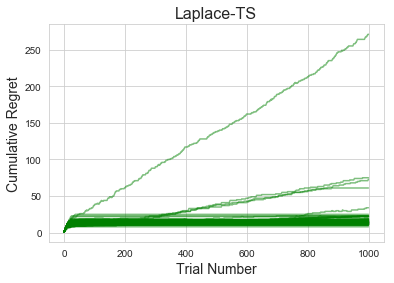

In [33]:
plot_cum_regret(laplace_ts_rewards, laplace_ts_optimal_rewards,
                color='green', title='Laplace-TS');